In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

with open('./../models/logistic_model.pkl', 'rb') as f:
    model = pickle.load(f)

df_valid = pd.read_csv('./../data/processed/valid_woe_features.csv')

feature_cols = ['int_rate_woe', 'fico_range_low_woe', 'dti_woe', 'annual_inc_woe',
                'loan_amnt_woe', 'inq_last_6mths_woe', 'revol_util_woe',
                'term_woe', 'grade_woe', 'home_woe']

X_valid = df_valid[feature_cols].values
y_valid = df_valid['default'].values

pred_proba = model.predict_proba(X_valid)[:, 1]

print(f"Validation portfolio: {len(X_valid):,} loans")
print(f"Mean PD: {pred_proba.mean():.2%}")
print(f"Actual default rate: {y_valid.mean():.2%}")

Validation portfolio: 168,699 loans
Mean PD: 22.67%
Actual default rate: 23.12%


In [3]:
print("BASE CASE MONTE CARLO SIMULATION")
print("="*80)

n_simulations = 10000

np.random.seed(42)

portfolio_defaults = np.zeros(n_simulations)

print(f"Running {n_simulations:,} simulations...")

for sim in range(n_simulations):
    random_draws = np.random.random(len(pred_proba))
    defaults = (random_draws < pred_proba).astype(int)
    portfolio_defaults[sim] = defaults.sum()
    
    if (sim + 1) % 2000 == 0:
        print(f"  Completed {sim+1:,} simulations")

portfolio_default_rate = portfolio_defaults / len(pred_proba)

mean_default_rate = portfolio_default_rate.mean()
std_default_rate = portfolio_default_rate.std()
percentile_95 = np.percentile(portfolio_default_rate, 95)
percentile_99 = np.percentile(portfolio_default_rate, 99)

print("\nBASE CASE RESULTS:")
print(f"  Expected default rate: {mean_default_rate:.2%}")
print(f"  Std deviation: {std_default_rate:.4f}")
print(f"  95th percentile (VaR 95%): {percentile_95:.2%}")
print(f"  99th percentile (VaR 99%): {percentile_99:.2%}")
print(f"  Actual observed: {y_valid.mean():.2%}")

BASE CASE MONTE CARLO SIMULATION
Running 10,000 simulations...
  Completed 2,000 simulations
  Completed 4,000 simulations
  Completed 6,000 simulations
  Completed 8,000 simulations
  Completed 10,000 simulations

BASE CASE RESULTS:
  Expected default rate: 22.67%
  Std deviation: 0.0010
  95th percentile (VaR 95%): 22.83%
  99th percentile (VaR 99%): 22.89%
  Actual observed: 23.12%


In [4]:
print("\nRECESSION STRESS SCENARIO")
print("="*80)

stress_factor_recession = 1.5

pred_proba_recession = np.minimum(pred_proba * stress_factor_recession, 1.0)

print(f"Mean PD before stress: {pred_proba.mean():.2%}")
print(f"Mean PD after stress: {pred_proba_recession.mean():.2%}")

portfolio_defaults_recession = np.zeros(n_simulations)

print(f"\nRunning {n_simulations:,} simulations under recession...")

for sim in range(n_simulations):
    random_draws = np.random.random(len(pred_proba_recession))
    defaults = (random_draws < pred_proba_recession).astype(int)
    portfolio_defaults_recession[sim] = defaults.sum()
    
    if (sim + 1) % 2000 == 0:
        print(f"  Completed {sim+1:,} simulations")

portfolio_default_rate_recession = portfolio_defaults_recession / len(pred_proba_recession)

mean_recession = portfolio_default_rate_recession.mean()
std_recession = portfolio_default_rate_recession.std()
percentile_95_recession = np.percentile(portfolio_default_rate_recession, 95)
percentile_99_recession = np.percentile(portfolio_default_rate_recession, 99)

print("\nRECESSION SCENARIO RESULTS:")
print(f"  Expected default rate: {mean_recession:.2%}")
print(f"  Std deviation: {std_recession:.4f}")
print(f"  95th percentile (VaR 95%): {percentile_95_recession:.2%}")
print(f"  99th percentile (VaR 99%): {percentile_99_recession:.2%}")
print(f"\n  Increase from base: {mean_recession - mean_default_rate:.2%}")


RECESSION STRESS SCENARIO
Mean PD before stress: 22.67%
Mean PD after stress: 33.99%

Running 10,000 simulations under recession...
  Completed 2,000 simulations
  Completed 4,000 simulations
  Completed 6,000 simulations
  Completed 8,000 simulations
  Completed 10,000 simulations

RECESSION SCENARIO RESULTS:
  Expected default rate: 34.00%
  Std deviation: 0.0010
  95th percentile (VaR 95%): 34.16%
  99th percentile (VaR 99%): 34.23%

  Increase from base: 11.33%


In [5]:
print("\nSEGMENT-SPECIFIC STRESS SCENARIO")
print("="*80)

high_risk_threshold = np.percentile(pred_proba, 75)

print(f"High-risk threshold (75th percentile): {high_risk_threshold:.2%}")

pred_proba_segment_stress = pred_proba.copy()

high_risk_mask = pred_proba > high_risk_threshold

pred_proba_segment_stress[high_risk_mask] = np.minimum(
    pred_proba_segment_stress[high_risk_mask] * 2.0, 1.0
)

print(f"\nBorrowers affected: {high_risk_mask.sum():,} ({100*high_risk_mask.sum()/len(pred_proba):.1f}%)")
print(f"Mean PD (high-risk segment) before: {pred_proba[high_risk_mask].mean():.2%}")
print(f"Mean PD (high-risk segment) after: {pred_proba_segment_stress[high_risk_mask].mean():.2%}")
print(f"Mean PD (portfolio) after: {pred_proba_segment_stress.mean():.2%}")

portfolio_defaults_segment = np.zeros(n_simulations)

print(f"\nRunning {n_simulations:,} simulations under segment stress...")

for sim in range(n_simulations):
    random_draws = np.random.random(len(pred_proba_segment_stress))
    defaults = (random_draws < pred_proba_segment_stress).astype(int)
    portfolio_defaults_segment[sim] = defaults.sum()
    
    if (sim + 1) % 2000 == 0:
        print(f"  Completed {sim+1:,} simulations")

portfolio_default_rate_segment = portfolio_defaults_segment / len(pred_proba_segment_stress)

mean_segment = portfolio_default_rate_segment.mean()
std_segment = portfolio_default_rate_segment.std()
percentile_95_segment = np.percentile(portfolio_default_rate_segment, 95)
percentile_99_segment = np.percentile(portfolio_default_rate_segment, 99)

print("\nSEGMENT STRESS RESULTS:")
print(f"  Expected default rate: {mean_segment:.2%}")
print(f"  Std deviation: {std_segment:.4f}")
print(f"  95th percentile (VaR 95%): {percentile_95_segment:.2%}")
print(f"  99th percentile (VaR 99%): {percentile_99_segment:.2%}")
print(f"\n  Increase from base: {mean_segment - mean_default_rate:.2%}")


SEGMENT-SPECIFIC STRESS SCENARIO
High-risk threshold (75th percentile): 30.94%

Borrowers affected: 42,174 (25.0%)
Mean PD (high-risk segment) before: 42.42%
Mean PD (high-risk segment) after: 81.88%
Mean PD (portfolio) after: 32.53%

Running 10,000 simulations under segment stress...
  Completed 2,000 simulations
  Completed 4,000 simulations
  Completed 6,000 simulations
  Completed 8,000 simulations
  Completed 10,000 simulations

SEGMENT STRESS RESULTS:
  Expected default rate: 32.53%
  Std deviation: 0.0009
  95th percentile (VaR 95%): 32.68%
  99th percentile (VaR 99%): 32.74%

  Increase from base: 9.86%


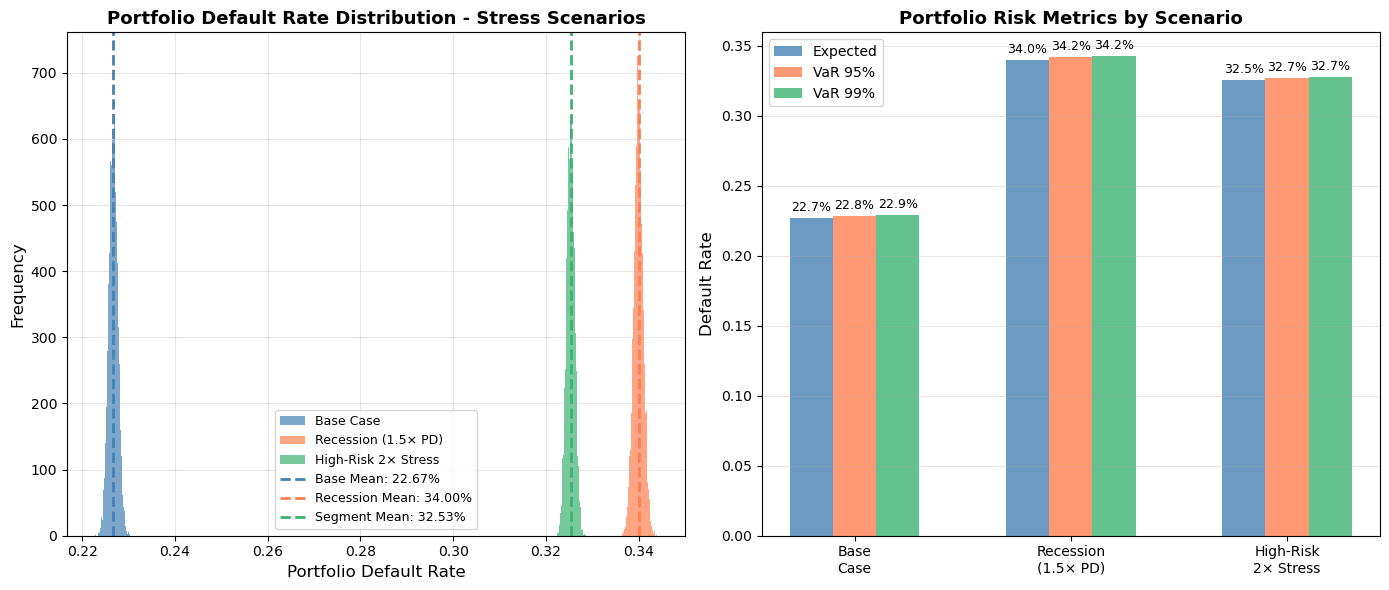

Stress scenario comparison plot saved


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(portfolio_default_rate, bins=50, alpha=0.7, label='Base Case', color='steelblue')
axes[0].hist(portfolio_default_rate_recession, bins=50, alpha=0.7, label='Recession (1.5× PD)', color='coral')
axes[0].hist(portfolio_default_rate_segment, bins=50, alpha=0.7, label='High-Risk 2× Stress', color='mediumseagreen')

axes[0].axvline(mean_default_rate, color='steelblue', linestyle='--', linewidth=2, label=f'Base Mean: {mean_default_rate:.2%}')
axes[0].axvline(mean_recession, color='coral', linestyle='--', linewidth=2, label=f'Recession Mean: {mean_recession:.2%}')
axes[0].axvline(mean_segment, color='mediumseagreen', linestyle='--', linewidth=2, label=f'Segment Mean: {mean_segment:.2%}')

axes[0].set_xlabel('Portfolio Default Rate', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Portfolio Default Rate Distribution - Stress Scenarios', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

scenarios = ['Base\nCase', 'Recession\n(1.5× PD)', 'High-Risk\n2× Stress']
means = [mean_default_rate, mean_recession, mean_segment]
var_95 = [percentile_95, percentile_95_recession, percentile_95_segment]
var_99 = [percentile_99, percentile_99_recession, percentile_99_segment]

x_pos = range(len(scenarios))

axes[1].bar([i-0.2 for i in x_pos], means, width=0.2, label='Expected', alpha=0.8, color='steelblue')
axes[1].bar(x_pos, var_95, width=0.2, label='VaR 95%', alpha=0.8, color='coral')
axes[1].bar([i+0.2 for i in x_pos], var_99, width=0.2, label='VaR 99%', alpha=0.8, color='mediumseagreen')

axes[1].set_ylabel('Default Rate', fontsize=12)
axes[1].set_title('Portfolio Risk Metrics by Scenario', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(scenarios)
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

for i in range(len(scenarios)):
    axes[1].text(i-0.2, means[i]+0.005, f'{means[i]:.1%}', ha='center', fontsize=9)
    axes[1].text(i, var_95[i]+0.005, f'{var_95[i]:.1%}', ha='center', fontsize=9)
    axes[1].text(i+0.2, var_99[i]+0.005, f'{var_99[i]:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./../figures/monte_carlo_stress_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stress scenario comparison plot saved")

In [7]:
def calculate_cvar(portfolio_defaults, confidence_level):
    var_threshold = np.percentile(portfolio_defaults, confidence_level * 100)
    tail_losses = portfolio_defaults[portfolio_defaults >= var_threshold]
    cvar = tail_losses.mean()
    return cvar

cvar_95_base = calculate_cvar(portfolio_default_rate, 0.95) 
cvar_99_base = calculate_cvar(portfolio_default_rate, 0.99)

cvar_95_recession = calculate_cvar(portfolio_default_rate_recession, 0.95)
cvar_99_recession = calculate_cvar(portfolio_default_rate_recession, 0.99)

cvar_95_segment = calculate_cvar(portfolio_default_rate_segment, 0.95)
cvar_99_segment = calculate_cvar(portfolio_default_rate_segment, 0.99)

print("\nEXPECTED SHORTFALL (CVaR) - TAIL RISK MEASURE")
print("="*80)
print(f"{'Scenario':<25} {'CVaR 95%':<15} {'CVaR 99%'}")
print("-"*80)
print(f"{'Base Case':<25} {cvar_95_base:<15.2%} {cvar_99_base:.2%}")
print(f"{'Recession (1.5× PD)':<25} {cvar_95_recession:<15.2%} {cvar_99_recession:.2%}")
print(f"{'High-Risk 2× Stress':<25} {cvar_95_segment:<15.2%} {cvar_99_segment:.2%}")

print("\nInterpretation:")
print("CVaR = Expected loss given that we're in the worst 5% (or 1%) of outcomes")

results_df = pd.DataFrame()
results_df['Scenario'] = ['Base Case', 'Recession (1.5× PD)', 'High-Risk 2× Stress']
results_df['Expected_Default_Rate'] = [mean_default_rate, mean_recession, mean_segment]
results_df['Std_Dev'] = [std_default_rate, std_recession, std_segment]
results_df['VaR_95'] = [percentile_95, percentile_95_recession, percentile_95_segment]
results_df['VaR_99'] = [percentile_99, percentile_99_recession, percentile_99_segment]
results_df['CVaR_95'] = [cvar_95_base, cvar_95_recession, cvar_95_segment]
results_df['CVaR_99'] = [cvar_99_base, cvar_99_recession, cvar_99_segment]

results_df.to_csv('./../data/processed/stress_test_results.csv', index=False)

print("\nStress test results saved")


EXPECTED SHORTFALL (CVaR) - TAIL RISK MEASURE
Scenario                  CVaR 95%        CVaR 99%
--------------------------------------------------------------------------------
Base Case                 22.87%          22.92%
Recession (1.5× PD)       34.21%          34.27%
High-Risk 2× Stress       32.71%          32.76%

Interpretation:
CVaR = Expected loss given that we're in the worst 5% (or 1%) of outcomes

Stress test results saved


In [9]:
import os
os.makedirs('./../models', exist_ok=True)

stress_test_summary = f"""
MONTE CARLO STRESS TESTING - PORTFOLIO RISK ANALYSIS
====================================================

Simulation Framework:
  Portfolio size: {len(pred_proba):,} loans
  Number of simulations: {n_simulations:,}
  Model: Logistic regression (Gini 0.394)
  Base expected default rate: {mean_default_rate:.2%}

Stress Scenarios Tested:

1. BASE CASE (No Stress)
   Expected default rate: {mean_default_rate:.2%}
   Standard deviation: {std_default_rate:.4f}
   VaR 95%: {percentile_95:.2%}
   VaR 99%: {percentile_99:.2%}
   CVaR 95%: {cvar_95_base:.2%}
   CVaR 99%: {cvar_99_base:.2%}

2. RECESSION SCENARIO (All PDs x 1.5)
   Expected default rate: {mean_recession:.2%}
   Standard deviation: {std_recession:.4f}
   VaR 95%: {percentile_95_recession:.2%}
   VaR 99%: {percentile_99_recession:.2%}
   CVaR 95%: {cvar_95_recession:.2%}
   CVaR 99%: {cvar_99_recession:.2%}
   
   Impact: +{mean_recession - mean_default_rate:.1%}pp increase in defaults

3. SEGMENT-SPECIFIC STRESS (High-risk 2x stressed)
   Affected borrowers: {high_risk_mask.sum():,} ({100*high_risk_mask.sum()/len(pred_proba):.1f}%)
   Expected default rate: {mean_segment:.2%}
   Standard deviation: {std_segment:.4f}
   VaR 95%: {percentile_95_segment:.2%}
   VaR 99%: {percentile_99_segment:.2%}
   CVaR 95%: {cvar_95_segment:.2%}
   CVaR 99%: {cvar_99_segment:.2%}
   
   Impact: +{mean_segment - mean_default_rate:.1%}pp increase in defaults

Key Insights:
1. Recession scenario is most severe: defaults rise from 22.7% to 34.0%
2. High-risk segment concentration risk: top 25% borrowers drive 9.9pp increase
3. Tail risk (CVaR): In worst 5% scenarios, expect 34.2% defaults under recession
4. Portfolio has significant downside risk requiring capital buffers

Business Value:
- Early warning system for capital adequacy
- Scenario planning for different economic conditions  
- Portfolio concentration risk identification
- Risk-adjusted pricing inputs
- Regulatory stress testing compliance

Status: Ready for risk committee review and capital planning integration
"""

print(stress_test_summary)

with open('./../reports/monte_carlo_stress_test_summary.txt', 'w') as f:
    f.write(stress_test_summary)

print("\nMonte Carlo summary saved")


MONTE CARLO STRESS TESTING - PORTFOLIO RISK ANALYSIS

Simulation Framework:
  Portfolio size: 168,699 loans
  Number of simulations: 10,000
  Model: Logistic regression (Gini 0.394)
  Base expected default rate: 22.67%

Stress Scenarios Tested:

1. BASE CASE (No Stress)
   Expected default rate: 22.67%
   Standard deviation: 0.0010
   VaR 95%: 22.83%
   VaR 99%: 22.89%
   CVaR 95%: 22.87%
   CVaR 99%: 22.92%

2. RECESSION SCENARIO (All PDs x 1.5)
   Expected default rate: 34.00%
   Standard deviation: 0.0010
   VaR 95%: 34.16%
   VaR 99%: 34.23%
   CVaR 95%: 34.21%
   CVaR 99%: 34.27%

   Impact: +11.3%pp increase in defaults

3. SEGMENT-SPECIFIC STRESS (High-risk 2x stressed)
   Affected borrowers: 42,174 (25.0%)
   Expected default rate: 32.53%
   Standard deviation: 0.0009
   VaR 95%: 32.68%
   VaR 99%: 32.74%
   CVaR 95%: 32.71%
   CVaR 99%: 32.76%

   Impact: +9.9%pp increase in defaults

Key Insights:
1. Recession scenario is most severe: defaults rise from 22.7% to 34.0%
2. Hig